Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

**Importing Skin Cancer Data**

To do: Take necessary actions to read the data

**Importing all the important libraries**

In [1]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D

import warnings
warnings.filterwarnings('ignore')

In [2]:
## If you are using the data by mounting the google drive, use the following :
from google.colab import drive
drive.mount('/content/gdrive')

##Ref:https://towardsdatascience.com/downloading-datasets-into-google-drive-via-google-colab-bcb1b30b0166

Mounted at /content/gdrive


This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [3]:
# Defining the path for train and test images
## Todo: Update the paths of the train and test dataset
data_dir_train = pathlib.Path("/content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train")
data_dir_test = pathlib.Path('/content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Test')

In [4]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


**Load using keras.preprocessing**

Let's load these images off disk using the helpful image_dataset_from_directory utility.

**Create a dataset**

Define some parameters for the loader:

In [5]:
batch_size = 32 
img_height = 180 
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [6]:
## Write your train dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset

train_ds = tf.keras.utils.image_dataset_from_directory(
            data_dir_train,
            batch_size=batch_size,
            image_size=(img_height, img_width),
            seed=123,
            validation_split=0.2,
            subset='training',
            )

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [7]:
## Write your validation dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
val_ds = tf.keras.utils.image_dataset_from_directory(
            data_dir_train,
            batch_size=batch_size,
            image_size=(img_height, img_width),
            seed=123,
            validation_split=0.2,
            subset='validation',
            )

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [8]:
# List out all the classes of skin cancer and store them in a list. 
# You can find the class names in the class_names attribute on these datasets. 
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


**Visualize the data**

Todo, create a code to visualize one instance of all the nine classes present in the dataset

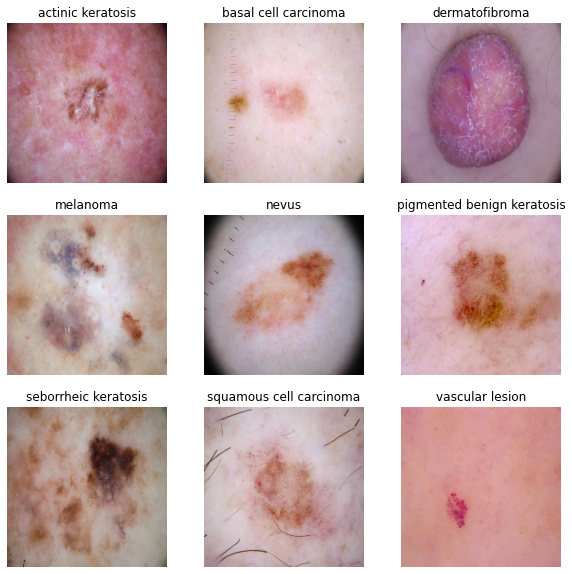

In [9]:
import matplotlib.pyplot as plt

### your code goes here, you can use training or validation data to visualize
plt.figure(figsize=(10,10))

for i in range(len(class_names)):
    filtered_ds = train_ds.filter(lambda x, l: tf.math.equal(l[0], i))
    for image, label in filtered_ds.take(1):
        ax = plt.subplot(3, 3, i+1)
        plt.imshow(image[0].numpy().astype('uint8'))
        plt.title(class_names[label.numpy()[0]])
        plt.axis('off')

The image_batch is a tensor of the shape (32, 180, 180, 3). This is a batch of 32 images of shape 180x180x3 (the last dimension refers to color channels RGB).

The label_batch is a tensor of the shape (32,), these are corresponding labels to the 32 images.

Dataset.cache() keeps the images in memory after they're loaded off disk during the first epoch.

Dataset.prefetch() overlaps data preprocessing and model execution while training.

In [10]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

**Create the model**

**Todo: Create a CNN model, which can accurately detect 9 classes present in the dataset. Use** layers.experimental.preprocessing.Rescaling **to normalize pixel values between (0,1). The RGB channel values are in the [0, 255] range. This is not ideal for a neural network. Here, it is good to standardize values to be in the [0, 1]**

In [11]:
### Your code goes here

num_class = 9
model = tf.keras.Sequential([
    layers.experimental.preprocessing.Rescaling(scale = 1./255, input_shape = (180,180,3)),

    layers.Conv2D(32,3,padding='same',activation= 'relu'),
    layers.MaxPooling2D(pool_size = 2),    

    layers.Conv2D(64,3,padding='same',activation= 'relu'),
    layers.MaxPooling2D(pool_size = 2),

    layers.Conv2D(128,3,padding='same',activation= 'relu'),
    layers.MaxPooling2D(pool_size = 2),

    layers.Flatten(),
    layers.Dense(128,activation='relu'),

    layers.Dense(num_class, activation='softmax')
])

**Compile the model**

Choose an appropirate optimiser and loss function for model training

In [12]:
### Todo, choose an appropirate optimiser and loss function
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True),
              metrics=['accuracy'])

In [13]:
# View the summary of all layers
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 90, 90, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 45, 45, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 45, 45, 128)       7

**Train the model**

In [14]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 117s 1s/step - loss: 2.1804 - accuracy: 0.2589 - val_loss: 1.9085 - val_accuracy: 0.2707
Epoch 2/20
56/56 [==============================] - 3s 49ms/step - loss: 1.7671 - accuracy: 0.3666 - val_loss: 1.6010 - val_accuracy: 0.4519
Epoch 3/20
56/56 [==============================] - 3s 47ms/step - loss: 1.5563 - accuracy: 0.4554 - val_loss: 1.5208 - val_accuracy: 0.4720
Epoch 4/20
56/56 [==============================] - 3s 46ms/step - loss: 1.4210 - accuracy: 0.4989 - val_loss: 1.4596 - val_accuracy: 0.5168
Epoch 5/20
56/56 [==============================] - 2s 43ms/step - loss: 1.3908 - accuracy: 0.5022 - val_loss: 1.4820 - val_accuracy: 0.4855
Epoch 6/20
56/56 [==============================] - 2s 42ms/step - loss: 1.2664 - accuracy: 0.5614 - val_loss: 1.4143 - val_accuracy: 0.5280
Epoch 7/20
56/56 [==============================] - 2s 42ms/step - loss: 1.2247 - accuracy: 0.5664 - val_loss: 1.4728 - val_accuracy: 0.5078
Epoch 8/20
56

**Visualizing training results**

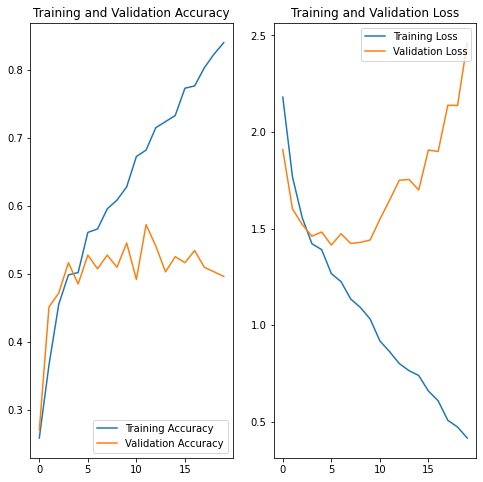

In [15]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

**Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit**

**Write your findings here**

- The model clearly overfits.

- The training accuracy is continuously increasing while the validation accuracy is fluctuating around 50%.

- The loss on training set decreases after each epoch but in case of the validation loss, its increasing after decreasing for few initial epochs.

- The model memorized the data instead of generalizing and learning real features and general relationships.

In [16]:
# Todo, after you have analysed the model fit history for presence of underfit or overfit, 
# choose an appropriate data augumentation strategy. 

data_augmentation = keras.Sequential([
    layers.experimental.preprocessing.RandomFlip(mode='horizontal_and_vertical', input_shape= (img_height, img_width, 3)),
    layers.experimental.preprocessing.RandomRotation(0.2),
    layers.experimental.preprocessing.RandomZoom(0.2),
    ])

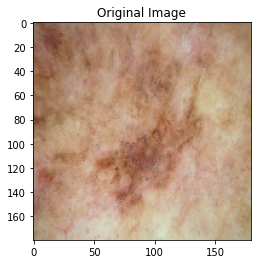

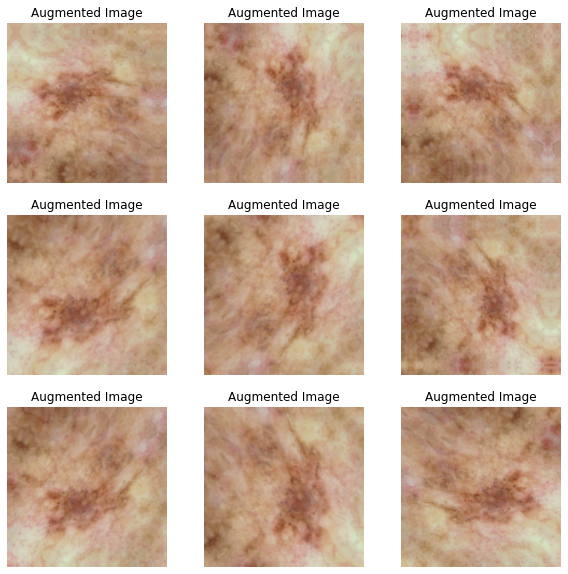

In [17]:
# Todo, visualize how your augmentation strategy works for one instance of training image.
# Your code goes here

for image, label in train_ds.take(1):
  plt.title("Original Image")
  plt.imshow(image[0]/255)
  plt.figure(figsize=(10,10))
  for i in range(9):
    augmented_image = data_augmentation(image, training=True)
    ax = plt.subplot(3, 3, i+1)
    plt.title("Augmented Image")
    plt.imshow(augmented_image[0]/255)
    plt.axis("off")


**Todo:**

**Create the model, compile and train the model**

**Along with augmentation, adding dropout considering previous experimentation is overfitted**

In [18]:
num_class = 9
model = tf.keras.Sequential([
    data_augmentation,
    layers.experimental.preprocessing.Rescaling(scale = 1./255, input_shape = (180,180,3)),

    layers.Conv2D(32,3,padding='same',activation= 'relu'),
    layers.MaxPooling2D(pool_size = 2, strides = 2),    
    layers.Dropout(0.2),

    layers.Conv2D(64,3,padding='same',activation= 'relu'),
    layers.MaxPooling2D(pool_size = 2, strides = 2),
    layers.Dropout(0.2),

    layers.Conv2D(128,3,padding='same',activation= 'relu'),
    layers.MaxPooling2D(pool_size = 2, strides = 2),
    layers.Dropout(0.2),

    layers.Flatten(),
    layers.Dense(128,activation='relu'),
    layers.Dropout(0.2),

    layers.Dense(num_class, activation='softmax')
])

**Compiling the model**

In [19]:
## Your code goes here
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True),
              metrics=['accuracy'])

**Training the model**

In [20]:
## Your code goes here, note: train your model for 20 epochs
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 5s 75ms/step - loss: 2.4640 - accuracy: 0.1875 - val_loss: 2.0884 - val_accuracy: 0.2640
Epoch 2/20
56/56 [==============================] - 4s 72ms/step - loss: 2.0388 - accuracy: 0.2148 - val_loss: 2.0587 - val_accuracy: 0.2215
Epoch 3/20
56/56 [==============================] - 4s 72ms/step - loss: 1.9215 - accuracy: 0.3013 - val_loss: 1.7662 - val_accuracy: 0.3960
Epoch 4/20
56/56 [==============================] - 4s 72ms/step - loss: 1.7578 - accuracy: 0.3733 - val_loss: 1.7158 - val_accuracy: 0.4183
Epoch 5/20
56/56 [==============================] - 4s 72ms/step - loss: 1.6437 - accuracy: 0.4035 - val_loss: 1.5348 - val_accuracy: 0.4631
Epoch 6/20
56/56 [==============================] - 4s 73ms/step - loss: 1.6000 - accuracy: 0.4364 - val_loss: 1.5853 - val_accuracy: 0.4474
Epoch 7/20
56/56 [==============================] - 4s 73ms/step - loss: 1.5059 - accuracy: 0.4754 - val_loss: 1.4790 - val_accuracy: 0.4855
Epoch 8/20
56

**Visualizing the results**

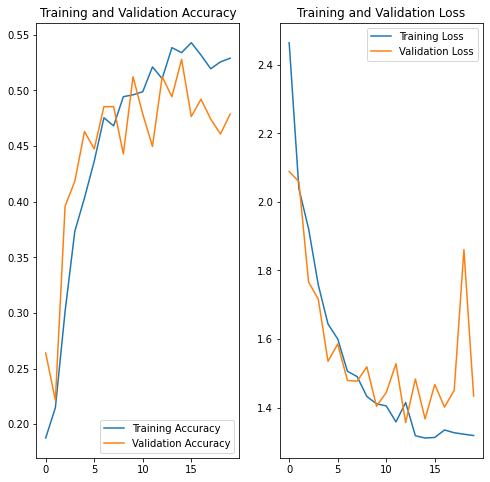

In [21]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

**Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit. Do you think there is some improvement now as compared to the previous model run?**

- The application of data augmentation and dropout layer reduced overfitting.
- Results on training and validation datasets are much closer.
- Overall accuracy is not high.

**Todo:** Find the distribution of classes in the training dataset.

**Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

<BarContainer object of 9 artists>

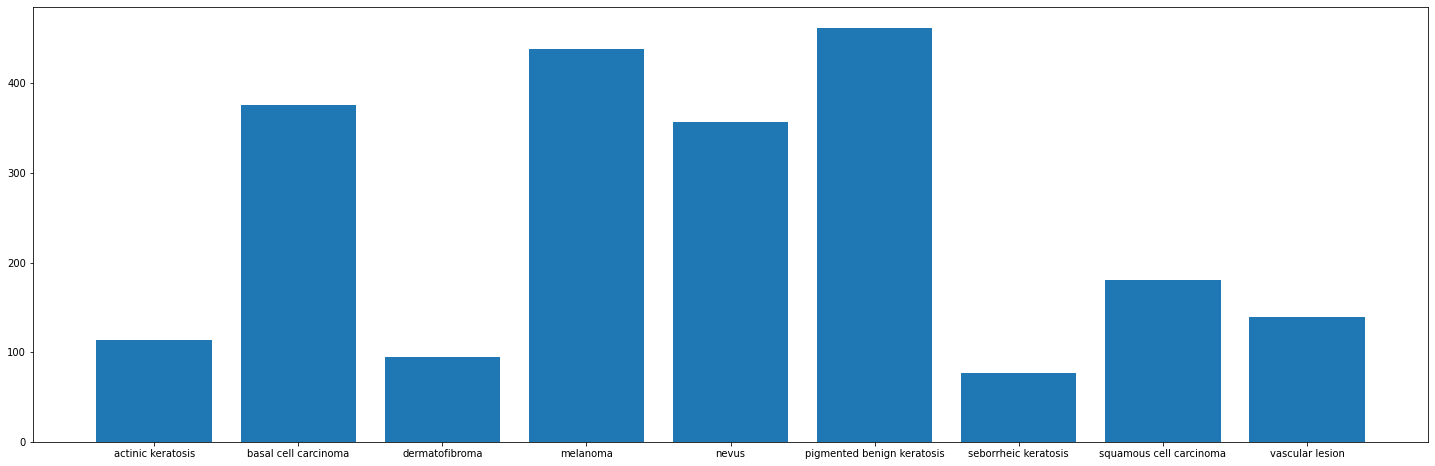

In [22]:
## Your code goes here.
class_count=[]
for i in class_names:
    class_count.append(len(list(data_dir_train.glob(i+'/*.jpg'))))
plt.figure(figsize=(25,8))
plt.bar(class_names,class_count)

**Todo: Write your findings here:**

**- Which class has the least number of samples?**
  - seborrheic keratosis

**- Which classes dominate the data in terms proportionate number of samples?**
  - pigmented benign keratosis
  - melanoma
  - basal cell carcinoma
  - nevus

**Todo:** Rectify the class imbalance

**Context:** You can use a python package known as Augmentor (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [23]:
!pip install Augmentor

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


To use Augmentor, the following general procedure is followed:

1. Instantiate a Pipeline object pointing to a directory containing your initial image data set.
2. Define a number of operations to perform on this data set using your Pipeline object.
3. Execute these operations by calling the Pipeline’s sample() method.

In [24]:
path_to_training_dataset='/content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/'
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to /content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F694646F290>: 100%|██████████| 500/500 [00:23<00:00, 21.69 Samples/s]


Initialised with 376 image(s) found.
Output directory set to /content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F6A32E3EC10>: 100%|██████████| 500/500 [00:24<00:00, 20.30 Samples/s]


Initialised with 95 image(s) found.
Output directory set to /content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F69A06227D0>: 100%|██████████| 500/500 [00:24<00:00, 20.74 Samples/s]


Initialised with 438 image(s) found.
Output directory set to /content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1024x768 at 0x7F69300EDA90>: 100%|██████████| 500/500 [01:42<00:00,  4.90 Samples/s]


Initialised with 357 image(s) found.
Output directory set to /content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=1504x1129 at 0x7F6930046BD0>: 100%|██████████| 500/500 [01:35<00:00,  5.24 Samples/s]


Initialised with 462 image(s) found.
Output directory set to /content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F69300E8650>: 100%|██████████| 500/500 [00:20<00:00, 24.69 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1024x768 at 0x7F69301B4E50>: 100%|██████████| 500/500 [00:49<00:00, 10.09 Samples/s]


Initialised with 181 image(s) found.
Output directory set to /content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F69A003D6D0>: 100%|██████████| 500/500 [00:19<00:00, 25.40 Samples/s]


Initialised with 139 image(s) found.
Output directory set to /content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7F693013E050>: 100%|██████████| 500/500 [00:20<00:00, 24.33 Samples/s]


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [25]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


**Lets see the distribution of augmented data after adding new images to the original training data.**

In [26]:
from glob import glob

path_list = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
path_list

['/content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0028941.jpg_4c7b8c9a-b4e6-4a4c-b723-fc660268ae8e.jpg',
 '/content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0029210.jpg_aedd813f-e00a-401a-996c-2aab3ef921bf.jpg',
 '/content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0029827.jpg_639d1783-948d-4441-b6a1-472b47c10298.jpg',
 '/content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0027615.jpg_e234b086-56e3-45ac-8374-822bdb2a64e6.jpg',
 '/content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0029830.jpg_f404dac2-a592

In [27]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new

['actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic 

In [28]:
dataframe_dict_new = dict(zip(path_list, lesion_list_new))

In [29]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
#new_df = original_df.append(df2)

In [30]:
df2['Label'].value_counts()

actinic keratosis             500
seborrheic keratosis          500
basal cell carcinoma          500
nevus                         500
melanoma                      500
squamous cell carcinoma       500
dermatofibroma                500
pigmented benign keratosis    500
vascular lesion               500
Name: Label, dtype: int64

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

**Todo:** **Train the model on the data created using Augmentor**

In [31]:
batch_size = 32
img_height = 180
img_width = 180

**Todo: Create a training dataset**

In [32]:
data_dir_train="/content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train"
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'training',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


**Todo: Create a validation dataset**

In [33]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'validation',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


**Todo: Create your model (make sure to include normalization)**

In [34]:
tf.keras.backend.clear_session()

num_class = 9
model = tf.keras.Sequential([
    layers.experimental.preprocessing.Rescaling(scale = 1./255, input_shape = (180,180,3)),
    
    layers.Conv2D(32,3,padding='same'),
    layers.Activation('relu'),
    layers.MaxPooling2D(pool_size = 2),    
    layers.Dropout(0.2),

    layers.Conv2D(64,3,padding='same'),
    layers.Activation('relu'),
    layers.MaxPooling2D(pool_size = 2),
    layers.Dropout(0.2),

    layers.Conv2D(128,3,padding='same'),
    layers.Activation('relu'),
    layers.MaxPooling2D(pool_size = 2),
    layers.Dropout(0.2),

    layers.Flatten(),
    layers.Dense(128),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.Dropout(0.2),

    layers.Dense(num_class, activation='softmax')
])

**Todo: Compile your model (Choose optimizer and loss function appropriately)**

In [35]:
## your code goes here
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

**Todo: Train your model**

In [36]:
epochs = 30

## Your code goes here, use 50 epochs.
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/30
169/169 [==============================] - 48s 268ms/step - loss: 1.7314 - accuracy: 0.3596 - val_loss: 4.5568 - val_accuracy: 0.1611
Epoch 2/30
169/169 [==============================] - 36s 208ms/step - loss: 1.3751 - accuracy: 0.4950 - val_loss: 2.6382 - val_accuracy: 0.3719
Epoch 3/30
169/169 [==============================] - 37s 212ms/step - loss: 1.2119 - accuracy: 0.5519 - val_loss: 2.2442 - val_accuracy: 0.3823
Epoch 4/30
169/169 [==============================] - 35s 200ms/step - loss: 1.1032 - accuracy: 0.5948 - val_loss: 1.3791 - val_accuracy: 0.4922
Epoch 5/30
169/169 [==============================] - 36s 209ms/step - loss: 0.9793 - accuracy: 0.6471 - val_loss: 1.2091 - val_accuracy: 0.5561
Epoch 6/30
169/169 [==============================] - 35s 198ms/step - loss: 0.8708 - accuracy: 0.6806 - val_loss: 1.2674 - val_accuracy: 0.5204
Epoch 7/30
169/169 [==============================] - 39s 222ms/step - loss: 0.7785 - accuracy: 0.7298 - val_loss: 1.1436 - val_ac

**Todo: Visualize the model results**

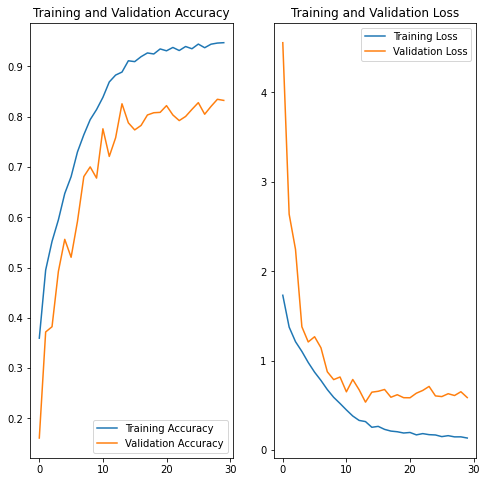

In [37]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [38]:
## With only Dropout, without BatchNormalization
tf.keras.backend.clear_session()

num_class = 9
model = tf.keras.Sequential([
    layers.experimental.preprocessing.Rescaling(scale = 1./255, input_shape = (180,180,3)),
    
    layers.Conv2D(32,3,padding='same'),
    layers.Activation('relu'),
    layers.MaxPooling2D(pool_size = 2),    
    layers.Dropout(0.2),

    layers.Conv2D(64,3,padding='same'),
    layers.Activation('relu'),
    layers.MaxPooling2D(pool_size = 2),
    layers.Dropout(0.2),

    layers.Conv2D(128,3,padding='same'),
    layers.Activation('relu'),
    layers.MaxPooling2D(pool_size = 2),
    layers.Dropout(0.2),

    layers.Flatten(),
    layers.Dense(128),
    layers.Activation('relu'),
    layers.Dropout(0.2),

    layers.Dense(num_class, activation='softmax')
])

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])


epochs = 30
## Your code goes here, use 50 epochs.
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/30
169/169 [==============================] - 38s 212ms/step - loss: 2.2261 - accuracy: 0.1493 - val_loss: 2.1672 - val_accuracy: 0.1693
Epoch 2/30
169/169 [==============================] - 36s 209ms/step - loss: 1.9685 - accuracy: 0.2405 - val_loss: 1.6214 - val_accuracy: 0.4120
Epoch 3/30
169/169 [==============================] - 37s 212ms/step - loss: 1.6392 - accuracy: 0.3796 - val_loss: 1.4796 - val_accuracy: 0.4566
Epoch 4/30
169/169 [==============================] - 35s 201ms/step - loss: 1.4692 - accuracy: 0.4423 - val_loss: 1.4485 - val_accuracy: 0.4529
Epoch 5/30
169/169 [==============================] - 36s 209ms/step - loss: 1.3595 - accuracy: 0.4748 - val_loss: 1.2394 - val_accuracy: 0.5345
Epoch 6/30
169/169 [==============================] - 35s 201ms/step - loss: 1.2664 - accuracy: 0.5202 - val_loss: 1.1441 - val_accuracy: 0.5798
Epoch 7/30
169/169 [==============================] - 37s 213ms/step - loss: 1.1897 - accuracy: 0.5497 - val_loss: 1.1533 - val_ac

**Todo: Visualize Results**

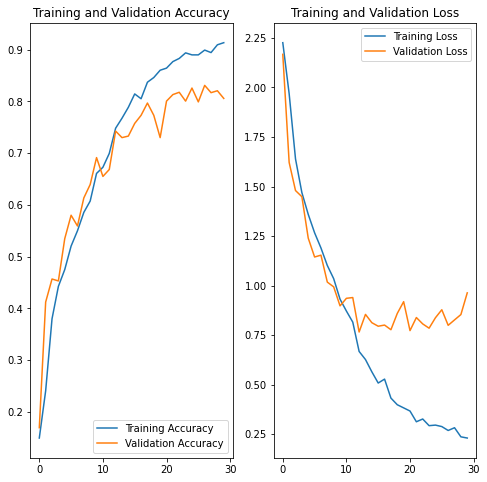

In [39]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

**Todo: Analyze your results here. Did you get rid of underfitting/overfitting? Did class rebalance help?**

- Changes done for data imbalance helped in improving training and validation accuracy.

- On top of data imbalance changes, tried two options
  - With dropout and batch normalization
  - With only dropout

- Even though validation accuracy increased, still there is 0.1 gap between training and validation accuracy.

In [40]:
#checking the performance on the test set 

from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score

test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_test,
    seed=123,
    batch_size=118,
    image_size=(img_height,img_width)
)

y_true=[]
y_pred=[]
for images, labels in test_ds.take(1):
  y_true=list(labels.numpy())
  predict_x=model.predict(images) 
  y_pred=np.argmax(predict_x,axis=1)
  print(classification_report(y_true,y_pred,target_names=class_names))
  print("Accuracy on test dataset : ",accuracy_score(y_true,y_pred))

Found 118 files belonging to 9 classes.
4/4 [==============================] - 0s 96ms/step
                            precision    recall  f1-score   support

         actinic keratosis       0.00      0.00      0.00        16
      basal cell carcinoma       0.38      0.31      0.34        16
            dermatofibroma       0.57      0.25      0.35        16
                  melanoma       0.30      0.19      0.23        16
                     nevus       0.37      0.69      0.48        16
pigmented benign keratosis       0.30      0.75      0.43        16
      seborrheic keratosis       0.00      0.00      0.00         3
   squamous cell carcinoma       0.45      0.31      0.37        16
           vascular lesion       1.00      0.67      0.80         3

                  accuracy                           0.36       118
                 macro avg       0.38      0.35      0.33       118
              weighted avg       0.35      0.36      0.32       118

Accuracy on test data